In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

class NoiseAdd(nn.Module):
    def __init__(self, std=1.0):
        super().__init__()
        self.std = std
    def forward(self,x):
        if self.training:
            return x + torch.randn_like(x).to(x.device) * self.std
        else:
            return x

def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    # return -torch.log(-torch.log(U + eps) + eps)
    return torch.log(U)-torch.log(1-U) # + eps) + eps)
def gumbel_softmax(logits, temperature=1.0, hard=False):
    g = sample_gumbel(logits.size())
    y = logits + g.to(logits.device)
    y = y / temperature
    y = F.softmax(y, dim=-1)
    if hard:
        # Straight-through
        max_idx = torch.argmax(y, dim=-1, keepdim=True)
        y_hard = torch.zeros_like(y).scatter_(-1, max_idx, 1.0)
        y = (y_hard - y).detach() + y
    return y
        

class GumbelBinaryAutoencoder(nn.Module):
    def __init__(self, input_dim=16, hidden_dim=8, std=1.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.Linear(32, hidden_dim * 2)  # 2 logits per latent dimension
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, 32),
            NoiseAdd(std),
            nn.Linear(32, 64),
            NoiseAdd(std),
            nn.Linear(64, input_dim),
            NoiseAdd(std),
            nn.Identity()
        )
    def forward(self, x):
        logits = self.encoder(x)
        logits = logits.view(-1, self.hidden_dim, 2)
        z = logits.view(-1, self.hidden_dim * 2)
        z = self.decoder(z)
        return z

In [5]:
dev = "cuda:4"

In [3]:
# dd = Decoder(16,8)
# x = torch.rand(2,16)
# torch.randn_like(x).to(x.device) * x.std(dim=0)

In [15]:
# 
# dd(torch.ones(2,16), True)
# test_samples.requires_grad(False)

In [23]:
def testing1(epochs=5000, std=1.0):
    loss_list_test, loss_list = [],[]
    input_dim, hidden_dim = 16, 8
    batch_size, lr = 1024, 1e-3
    # temperature schedule
    # temp_start = 1.0    # start with a higher temperature (more "soft")
    # temp_end   = 0.1    # end with a lower temperature (more "discrete")
    # temp_decay = (temp_end / temp_start) ** (1.0 / (epochs - 1))
    epoch_start = 0
    # rate = 1/(epochs-epoch_start) * (temp_start - temp_end)/temp_end
    DS = 2000
    # X = torch.rand(1000, input_dim)
    X = torch.cos(torch.arange(0,6.5,6.5/16)*2).unsqueeze(0).repeat(DS,1) + torch.randn(DS,input_dim)*5.25
    data_loader = torch.utils.data.DataLoader(X, batch_size=batch_size, shuffle=True)
    model = GumbelBinaryAutoencoder(input_dim, hidden_dim, std)
    model = model.to(dev)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    # temp = temp_start
    for epoch in range(epochs):
        total_loss = 0
        for i,batch in enumerate(data_loader):
            batch = batch.to(dev)
            out = model(batch)
            loss = criterion(out, batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * len(batch)
            
            # temp = t_func2(epoch*len(data_loader) + i ,temp_start,temp_end,(epochs-epoch_start)*len(data_loader),0.0)
            # temp_list.append(temp)
            loss_list.append(loss.item())
            
            # with torch.no_grad():
            #     test_samples = (torch.cos(torch.arange(0,6.5,6.5/16)*2).unsqueeze(0).repeat(DS,1) + torch.randn(DS,input_dim)*0.5)[:5].to(dev)
            #     reconstructed = model(test_samples, False)
            #     loss = criterion(out, batch)
            #     loss_list_test.append(loss.item())
        
        avg_loss = total_loss / len(X)
        if epoch % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
        
        
    # Quick test
    model.eval()
    with torch.no_grad():
        test_samples = (torch.cos(torch.arange(0,6.5,6.5/16)*2).unsqueeze(0).repeat(DS,1) + torch.randn(DS,input_dim)*0.5)[:5].to(dev)
        reconstructed = model(test_samples)
        print("Original:\n", test_samples)
        print("Reconstructed:\n", reconstructed)
    return test_samples, reconstructed, loss_list_test, loss_list, model

In [24]:
test_samples, reconstructed, loss_list_test, loss_list, model = testing1(5000,1.)

Epoch [1/5000], Loss: 29.995148
Epoch [101/5000], Loss: 7.549559
Epoch [201/5000], Loss: 3.207040
Epoch [301/5000], Loss: 2.832624
Epoch [401/5000], Loss: 2.731007
Epoch [501/5000], Loss: 2.659985
Epoch [601/5000], Loss: 2.632635
Epoch [701/5000], Loss: 2.598725
Epoch [801/5000], Loss: 1.149079
Epoch [901/5000], Loss: 1.110057
Epoch [1001/5000], Loss: 1.091518
Epoch [1101/5000], Loss: 1.073182
Epoch [1201/5000], Loss: 1.078076
Epoch [1301/5000], Loss: 1.060279
Epoch [1401/5000], Loss: 1.079144
Epoch [1501/5000], Loss: 1.050577
Epoch [1601/5000], Loss: 1.065192
Epoch [1701/5000], Loss: 1.060634
Epoch [1801/5000], Loss: 1.059104
Epoch [1901/5000], Loss: 1.041696
Epoch [2001/5000], Loss: 1.052632
Epoch [2101/5000], Loss: 1.054577
Epoch [2201/5000], Loss: 1.050929
Epoch [2301/5000], Loss: 1.053362
Epoch [2401/5000], Loss: 1.041772
Epoch [2501/5000], Loss: 1.045887
Epoch [2601/5000], Loss: 1.045388
Epoch [2701/5000], Loss: 1.035107
Epoch [2801/5000], Loss: 1.038243
Epoch [2901/5000], Loss: 

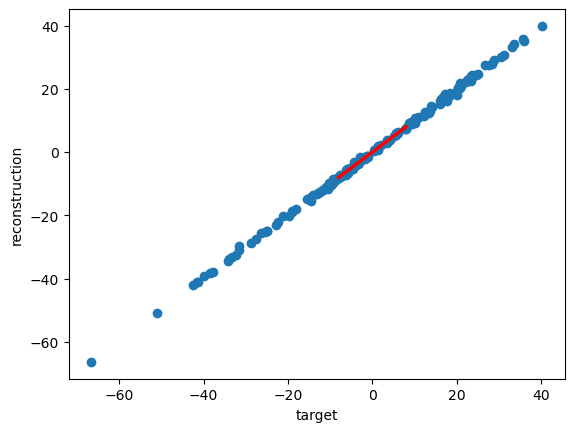

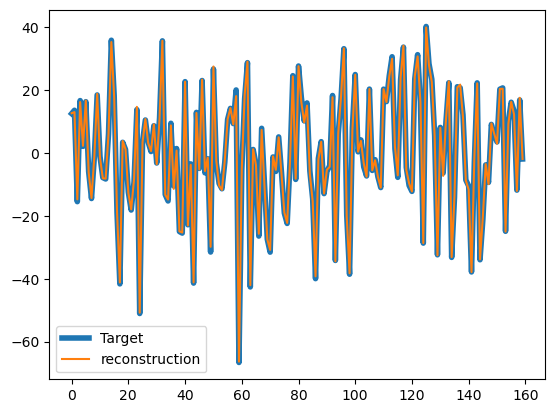

In [25]:
model.eval()
DS,input_dim = 2000, 16
# test_samples = (torch.sin(torch.arange(0,6.5,6.5/16)*2).unsqueeze(0).repeat(DS,1) + torch.randn(DS,input_dim)*5.25)[:7].to(dev)
test_samples = (torch.sin(torch.arange(0,6.5,6.5/16)*2).unsqueeze(0).repeat(DS,1)*torch.cos(torch.arange(0,6.5,6.5/16)*30).unsqueeze(0).repeat(DS,1)*torch.cos(torch.arange(0,6.5,6.5/16)*10).unsqueeze(0).repeat(DS,1) + torch.randn(DS,input_dim)*20.0)[:10].to(dev)
reconstructed = model(test_samples)
plt.scatter(test_samples.view(-1).detach().cpu(),reconstructed.view(-1).detach().cpu())
plt.xlabel("target")
plt.ylabel("reconstruction")
plt.plot([-8,8],[-8,8], c='red', lw=2.5)
plt.show()
plt.plot(test_samples.view(-1).detach().cpu(), lw=4)
plt.plot(reconstructed.view(-1).detach().cpu())
plt.legend(["Target", "reconstruction"])
plt.show()


In [8]:
# model.eval()
model.training

False

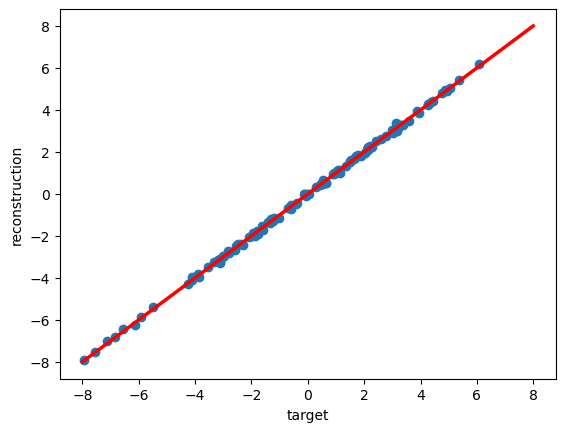

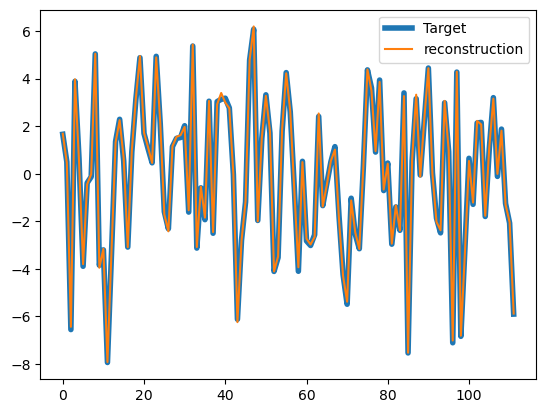

In [26]:
DS,input_dim = 2000, 16
test_samples = (torch.cos(torch.arange(0,6.5,6.5/16)*2).unsqueeze(0).repeat(DS,1) + torch.randn(DS,input_dim)*3.25)[:7].to(dev)
reconstructed = model(test_samples)
plt.scatter(test_samples.view(-1).detach().cpu(),reconstructed.view(-1).detach().cpu())
plt.xlabel("target")
plt.ylabel("reconstruction")
plt.plot([-8,8],[-8,8], c='red', lw=2.5)
plt.show()
plt.plot(test_samples.view(-1).detach().cpu(), lw=4)
plt.plot(reconstructed.view(-1).detach().cpu())
plt.legend(["Target", "reconstruction"])
plt.show()

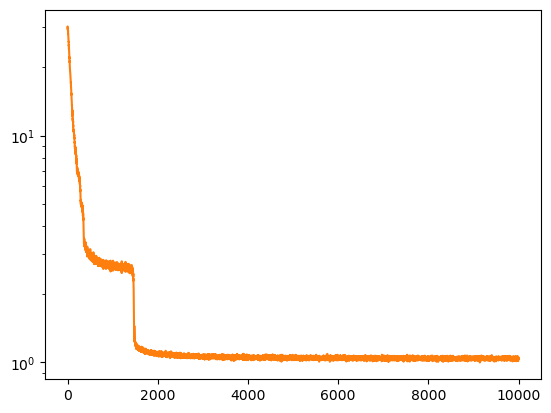

In [29]:
plt.plot(loss_list_test, lw=5)
plt.plot(loss_list)
plt.yscale('log')
# plt.xscale('log')
plt.show()

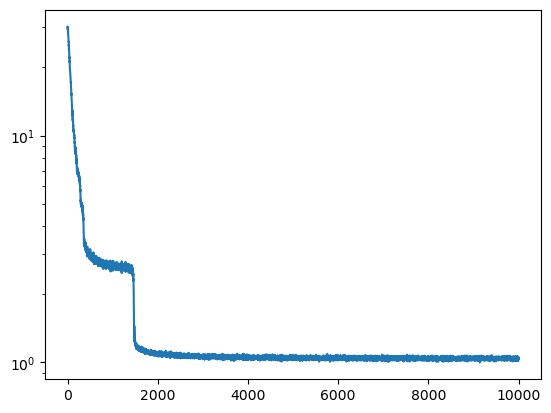

In [28]:
# plt.plot(np.array(temp_list)/100)
plt.plot(loss_list)
plt.yscale('log')
# plt.xscale('log')
plt.show()

In [82]:
################################